In [1]:
import sys
sys.path.append('/home/idnm/Programming projects/jax_circuits/')

from jax_circuits import *
from qiskit import transpile
from qiskit.circuit.library import *
from qiskit.quantum_info import OneQubitEulerDecomposer, random_clifford
from cp_utils import *
from scipy.stats import unitary_group

plt.rcParams.update({'font.size': 14})

To do

1. Local minima plots in an accurate way:
    1. For each ansatz several random unitaries and several self-unitaries. 
    1. Separately stats for different realizations of Toffoli 3 and Toffoli 4 gates.

# Local minimums

## Empirical success ratio: definition and example

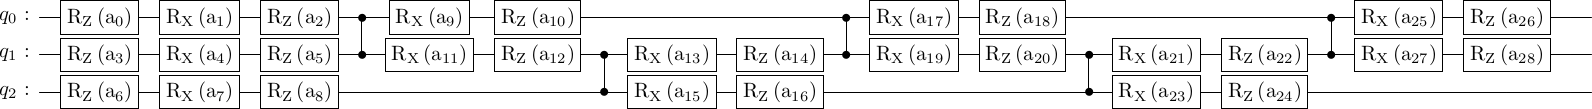

In [90]:
anz = Ansatz(3, 'cz', fill_layers(chain_layer(3), 5))
target_angles = random_angles(anz.num_angles)
target_circuit = anz.circuit(target_angles)
target_unitary = anz.unitary(target_angles)

anz.circuit().draw(output='latex')

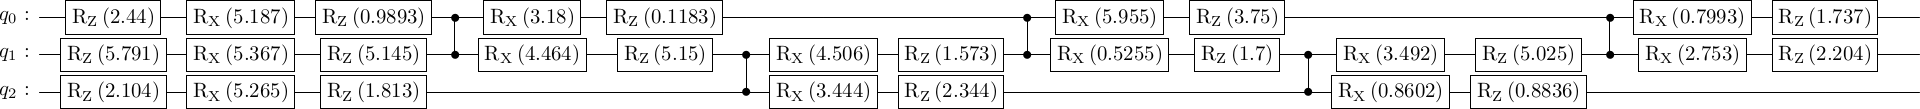

In [92]:
target_circuit.draw(output='latex')

Success ratio of out default optimization procedure is found as follows.

In [93]:
results = anz.learn(
    target_unitary, 
    method='adam',
    learning_rate=0.1,
    num_iterations=5000,
    num_repeats=100)

success_record = [jnp.min(r['loss'])<1e-4 for r in results]
sr = sum(success_record)/len(success_record)
print(f'Success Ratio is {sr}')

Success Ratio is 0.38999998569488525


## 3q chart

In [53]:
def mean_and_std(results):
    mean_list = []
    std_list = []
    for i in range(len(results[0])):
        sr_list = jnp.array([res[i]['success_ratio'] for res in results])
        mean_list.append(jnp.mean(sr_list))
        std_list.append(jnp.std(sr_list))
    
    return mean_list, std_list        

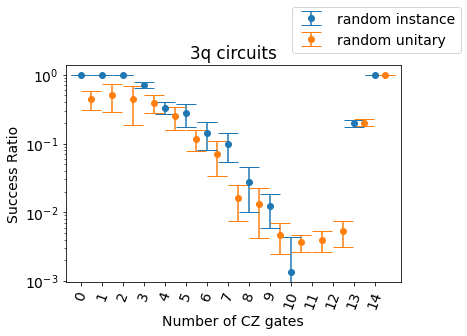

In [54]:
results_self = []
for i in range(10):
    with open(f'data/local_minimums/3q_random_self_rs{i}', 'rb')  as f:
        results_self.append(pickle.load(f))
        
results_unitary = []
for i in range(10):
    with open(f'data/local_minimums/3q_random_unitary_rs{i}', 'rb')  as f:
        results_unitary.append(pickle.load(f))        
        
mean_list_self, std_list_self = mean_and_std(results_self)
mean_list_unitary, std_list_unitary = mean_and_std(results_unitary)
plt.errorbar(range(len(mean_list_self)), mean_list_self, yerr=std_list_self, fmt='o', capsize=10, label='random instance')
plt.errorbar(jnp.arange(len(mean_list_unitary))+0.5, mean_list_unitary, yerr=std_list_unitary, fmt='o', capsize=10, label='random unitary')
plt.legend(bbox_to_anchor=(1.2, 1.3))

plt.yscale('log')
plt.xticks(range(len(mean_list_unitary)), rotation=70)
plt.ylabel('Success Ratio')
plt.xlabel('Number of CZ gates')
plt.title('3q circuits')
plt.savefig('figures/3q_success_chart', dpi=1000, bbox_inches='tight')

## 4q chart

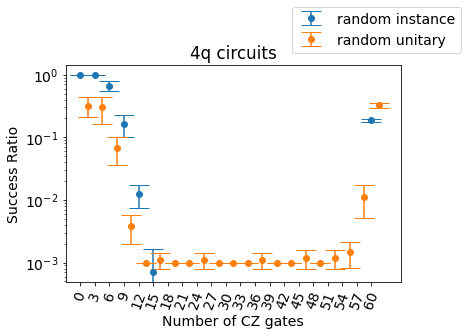

In [89]:
results_self = []
for i in range(10):
    with open(f'data/local_minimums/4q_random_self_rs{i}', 'rb')  as f:
        results_self.append(pickle.load(f))
        
results_unitary = []
for i in range(10):
    with open(f'data/local_minimums/4q_random_unitary_rs{i}', 'rb')  as f:
        results_unitary.append(pickle.load(f))        
        
mean_list_self, std_list_self = mean_and_std(results_self)
mean_list_unitary, std_list_unitary = mean_and_std(results_unitary)

xticks = jnp.arange(theoretical_lower_bound(4)+1)[::3]
plt.errorbar(xticks, mean_list_self, yerr=std_list_self, fmt='o', capsize=10, label='random instance')
plt.errorbar(xticks+1.5, mean_list_unitary, yerr=std_list_unitary, fmt='o', capsize=10, label='random unitary')
plt.legend(bbox_to_anchor=(1.2, 1.3))

plt.xlim([-3, 66])
plt.yscale('log')
plt.xticks(xticks, rotation=70)
plt.ylabel('Success Ratio')
plt.xlabel('Number of CZ gates')
plt.title('4q circuits')
plt.savefig('figures/4q_success_chart', dpi=1000, bbox_inches='tight')        

# CPFlow

## Main ideas

$CP$-templates.

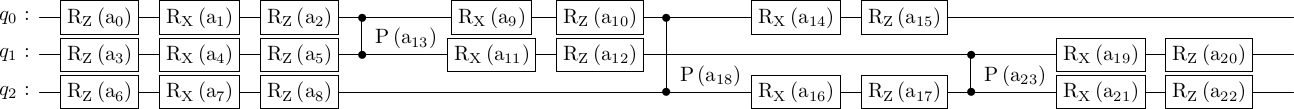

In [100]:
anz = Ansatz(3, 'cp', fill_layers(connected_layer(3),3))
anz.circuit().draw(output='latex')

Regularization function.

In [131]:
RegularizationOptions()

RegularizationOptions(function='linear', ymax=2, xmax=1.5707963267948966, plato_0=0.05, plato_1=0.05, plato_2=0.05)

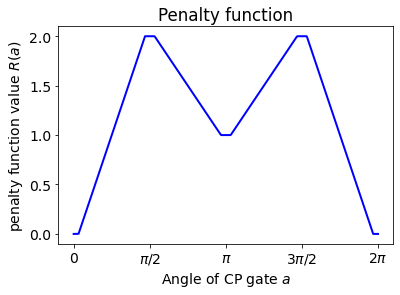

In [135]:
regularization_options = RegularizationOptions(plato_0=0.1, plato_1=0.1, plato_2=0.1)
regularization_func = make_regularization_function(regularization_options)
a_sweep = jnp.linspace(0, 2*jnp.pi, 500)

plt.plot(a_sweep, vmap(regularization_func)(a_sweep), 'blue', linewidth=2)
plt.xticks([0, jnp.pi/2, jnp.pi, 3*jnp.pi/2, 2*jnp.pi], ['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.title('Penalty function')
plt.ylabel('penalty function value $R(a)$')
plt.xlabel('Angle of CP gate $a$')
plt.savefig('figures/penalty', dpi=1000, bbox_inches='tight')        

# Toffoli

## Toffoli 3

### Connected

Optimal hyperparameters: k=6, r=0.0008221072385346347
Optimal decompositions (out of 100): 49


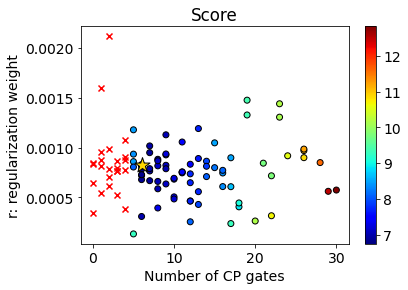

In [2]:
results = Results.load('results/toff3_conn')
k_best, r_best = results.best_hyperparameters()[0]
optimal_decompositions = [d for d in results.decompositions if d.cz_count==6]
print(f'Optimal hyperparameters: k={k_best}, r={r_best}')
print(f'Optimal decompositions (out of 100): {len(optimal_decompositions)-1}')
results.plot_trials()
plt.savefig('figures/toff3_trials_conn', dpi=1000, bbox_inches='tight')        

Best circuits in each nomination. The circuit with the best $T$-depth is simultaneously the winner in all other nominations.

In [5]:
best_cz_count_decomposition = min(results.decompositions, key=lambda d: d.cz_count)
best_cz_depth_decomposition = min(results.decompositions, key=lambda d: d.cz_depth)
best_t_count_decomposition = min(results.decompositions, key=lambda d: d.t_count)
best_t_depth_decomposition = min(results.decompositions, key=lambda d: d.t_depth)

best_decomposition = best_t_depth_decomposition

print(best_cz_count_decomposition)
print(best_cz_depth_decomposition)
print(best_t_count_decomposition)
print(best_t_depth_decomposition)

< toff3_conn| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 6 | CZ depth: 6  | T count: 7 | T depth: 5 >
< toff3_conn| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 6 | CZ depth: 6  | T count: 7 | T depth: 5 >
< toff3_conn| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 6 | CZ depth: 6  | T count: 7 | T depth: 5 >
< toff3_conn| Clifford+T | loss: 3.5762786865234375e-07  | CZ count: 6 | CZ depth: 6  | T count: 7 | T depth: 4 >


This circuit won the appearance in the paper.

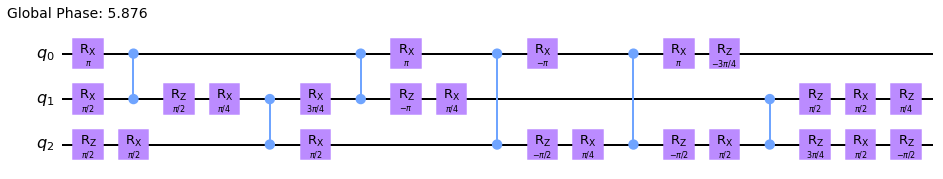

In [6]:
best_decomposition.circuit.draw(output='mpl')

### Chain

Optimal hyperparameters: k=14, r=0.0009562497402990495
Optimal decompositions (out of 100): 8


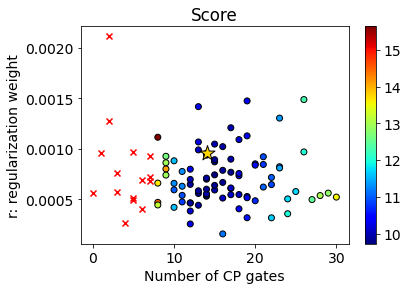

In [2]:
results = Results.load('results/toff3_chain')
k_best, r_best = results.best_hyperparameters()[0]
optimal_decompositions = [d for d in results.decompositions if d.cz_count==8]
print(f'Optimal hyperparameters: k={k_best}, r={r_best}')
print(f'Optimal decompositions (out of 100): {len(optimal_decompositions)-1}')
results.plot_trials()
plt.savefig('figures/toff3_trials_chain', dpi=1000, bbox_inches='tight')        

Again, the best overall decomposition turns out to be the onewith the smallest $T$-depth.

In [7]:
for d in tqdm(results.decompositions):
    d.refine()

  0%|          | 0/70 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
clifford_T_decompositions = [d for d in results.decompositions if d.t_count is not None]

best_cz_count_decomposition = min(clifford_T_decompositions, key=lambda d: d.cz_count)
best_cz_depth_decomposition = min(clifford_T_decompositions, key=lambda d: d.cz_depth)
best_t_count_decomposition = min(clifford_T_decompositions, key=lambda d: d.t_count)
best_t_depth_decomposition = min(clifford_T_decompositions, key=lambda d: d.t_depth)

best_decomposition = best_t_depth_decomposition

print(best_cz_count_decomposition)
print(best_cz_depth_decomposition)
print(best_t_count_decomposition)
print(best_t_depth_decomposition)

< toff3_chain| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >
< toff3_chain| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >
< toff3_chain| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 4 >
< toff3_chain| Clifford+T | loss: 1.1920928955078125e-07  | CZ count: 8 | CZ depth: 8  | T count: 7 | T depth: 3 >


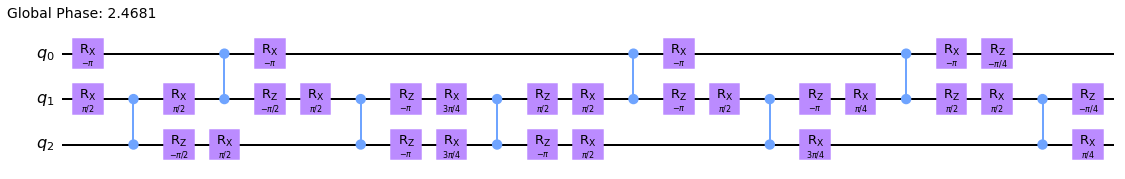

In [15]:
qc = best_decomposition.circuit
qc.draw(output='mpl')

## Toffoli 4

### Connected

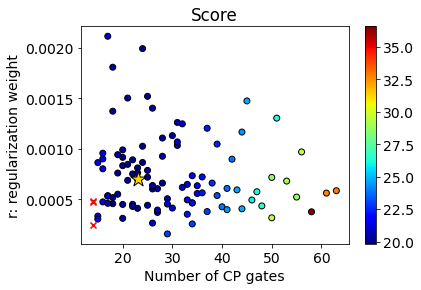

In [18]:
results = Results.load('results/toff4_conn')
d = results.decompositions[-1]
results.plot_trials()

In [21]:
d.refine()

'Refined to Rational'

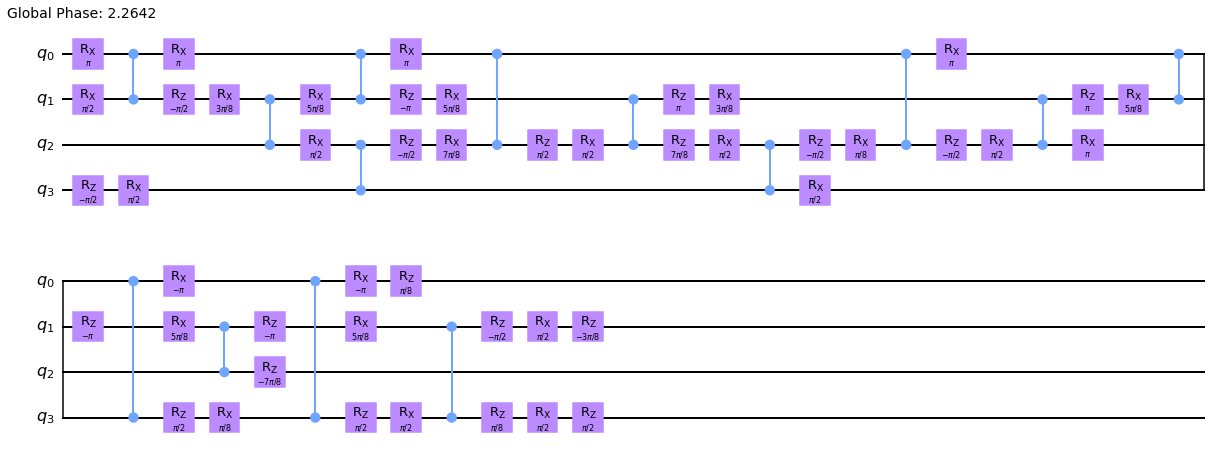

In [22]:
d.circuit.draw(output='mpl')

### Chain

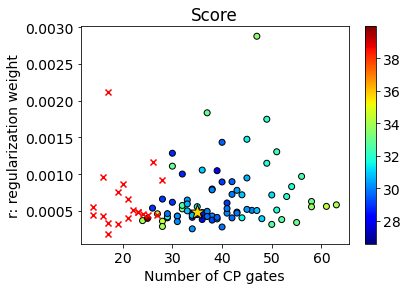

In [24]:
results = Results.load('results/toff4_chain')
results.plot_trials()

In [26]:
d = results.decompositions[-1]
d.refine()

'Refined to Rational'

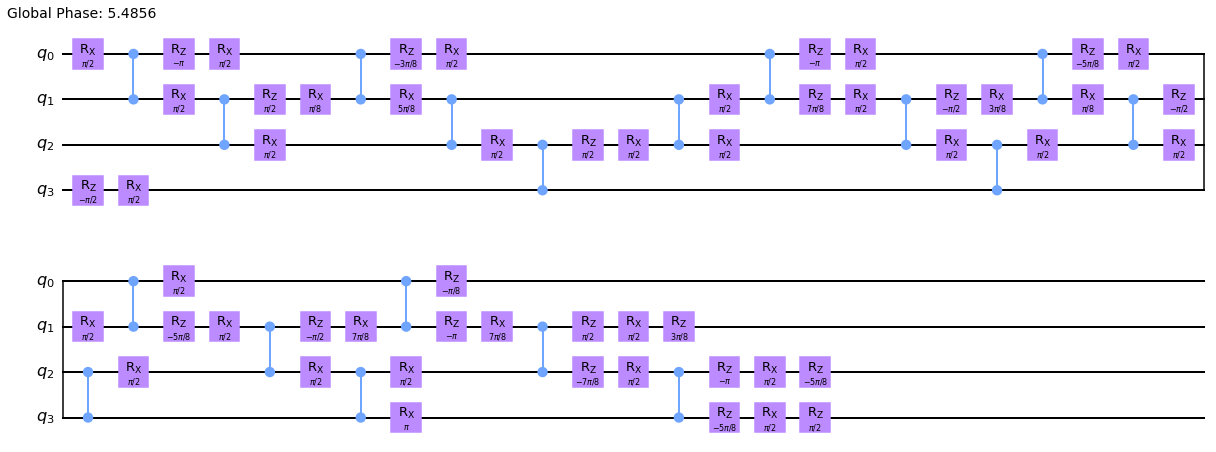

In [28]:
d.circuit.draw(output='mpl')

### Star

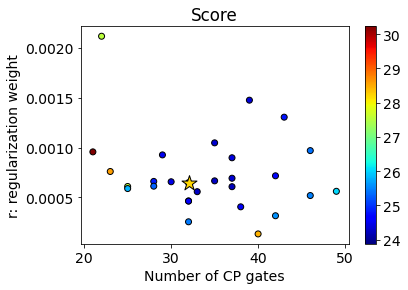

In [2]:
results = Results.load('results/toff4_star_rxry')
results.plot_trials()

In [3]:
d = results.decompositions[-1]
d

< toff4_star_rxry| Approximate | loss: 3.5762786865234375e-07  | CZ count: 16 | CZ depth: 16  >

In [ ]:
d.refine()

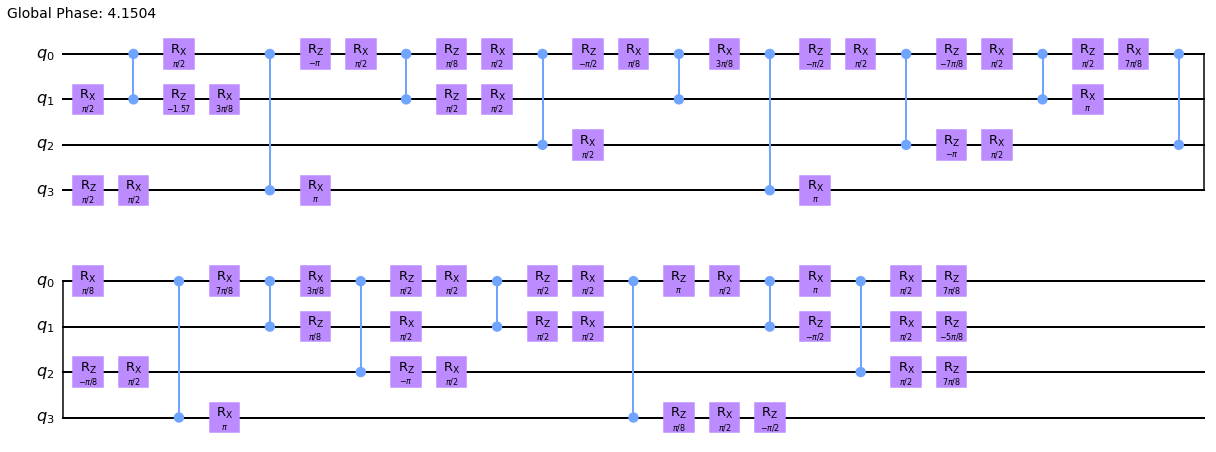

In [10]:
d.circuit.draw(output='mpl')

In [15]:
from exact_decompositions import *

In [43]:
jnp.pi/64

0.04908738521234052

In [40]:
qc = QuantumCircuit(1)
qc.rz(1.5718374252319336, 0)

qr = rationalize_all_rgates(qc, angle_threshold=1e-2)
qr.draw()

┌─────────┐
q: ┤ Rz(π/2) ├
   └─────────┘

In [37]:
angle = 1.5718
power = 4
max_denominator = 2**power

f = Fraction.from_float(angle / jnp.pi).limit_denominator(max_denominator)
rational_angle = jnp.pi*f
f

Fraction(1, 2)

In [38]:
jnp.abs(rational_angle-angle)

DeviceArray(0.00100367, dtype=float32)

In [ ]:
f = Fraction(a/jnp.pi).limit_denominator(2**power)

In [22]:
1.5718/jnp.pi

0.5003194791036822

In [12]:
d.circuit.data

[(Instruction(name='rx', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), [Qubit(QuantumRegister(4, 'q'), 1)], []), (Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1)], []), (Instruction(name='rx', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), [Qubit(QuantumRegister(4, 'q'), 0)], []), (Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-1.5718374252319336]), [Qubit(QuantumRegister(4, 'q'), 1)], []), (Instruction(name='rx', num_qubits=1, num_clbits=0, params=[1.1780972450961724]), [Qubit(QuantumRegister(4, 'q'), 1)], []), (Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), [Qubit(QuantumRegister(4, 'q'), 3)], []), (Instruction(name='rx', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), [Qubit(QuantumRegister(4, 'q'), 3)], []), (Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(4, 'q'), 0), Qubit(Quantum

In [30]:
qc = results.decompositions[0].circuit

In [ ]:
qc.depth()

In [28]:
finite_results = [r for r in results.trials.results if r['cz_counts']]
cz_sorted_results = sorted(finite_results, key=lambda r: r['cz_counts'][0])


{'loss': 25.957138061523438,
 'status': 'ok',
 'random_seed': 142552679,
 'cz_counts': [18,
  21,
  21,
  21,
  21,
  22,
  22,
  22,
  22,
  22,
  22,
  23,
  23,
  23,
  24,
  24,
  26,
  26,
  26,
  30,
  32],
 'num_cp_gates': 30,
 'r': 0.0007911332934920287,
 'layer': [[0, 1], [0, 2], [0, 3]]}

In [52]:
results.best_hyperparameters()

[[35, 0.0007350500169631557],
 [39, 0.0005810089094131886],
 [34, 0.0008100124249010468],
 [33, 0.0007334173184246662],
 [34, 0.0002872329679569264],
 [37, 0.0005301174483203044],
 [40, 0.0005586980633067704],
 [42, 0.0005668578582002055],
 [43, 0.000749515807226956],
 [30, 0.0007911332934920287],
 [40, 0.00043028781201300226],
 [42, 0.0007421996693218663],
 [44, 0.000872330980877755],
 [36, 0.0004036332520927447],
 [36, 0.0006538863087132523],
 [32, 0.0006238309781559535],
 [36, 0.00048178882437686617],
 [39, 0.0007489813525877311],
 [41, 0.0006800376685323038],
 [34, 0.0007207224699008419],
 [42, 0.0005709630572632285],
 [33, 0.000594445179597674],
 [43, 0.0004985431611565476],
 [40, 0.0006665109304598836],
 [35, 0.0007671699582386612],
 [33, 0.0006830730333024403],
 [39, 0.0009021310884392261],
 [38, 0.00034398087887284605],
 [43, 0.00054875384858226],
 [35, 0.0008168577056782097],
 [40, 0.0014069694847469551],
 [32, 0.0010832136506113176],
 [43, 0.0004841852532173279],
 [42, 0.0007